Este testes mostram duas maneiras de carregar imagens do disco. 
- carregar e pré-processar um conjunto de dados de imagem usando camadas e utilitários de pré-processamento Keras.
- escrever um pipeline de entrada do zero usando tf.data .

## configurações

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.11.0


## Baixando o conjunto de dados de flores
Este tutorial usa um conjunto de dados de vários milhares de fotos de flores. O conjunto de dados de flores contém cinco subdiretórios, um por classe:

flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [9]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

### Após o download (218 MB), você deverá ter uma cópia das fotos das flores disponíveis. Há 3.670 imagens no total:

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### Cada diretório contém imagens desse tipo de flor. Aqui estão algumas rosas:

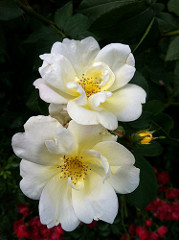

In [14]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### outra rosa

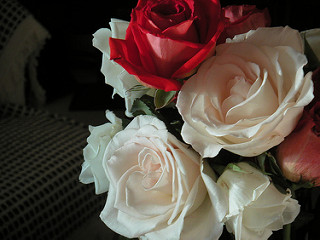

In [15]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

### Como carregar dados usando um utilitário Keras
Vamos carregar essas imagens do disco usando o útil utilitário tf.keras.utils.image_dataset_from_directory .

1 - Criar um conjunto de dados, definindo alguns parâmetros para o carregador:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

É uma boa prática usar uma divisão de validação ao desenvolver seu modelo. Você usará 80% das imagens para treinamento e 20% para validação.

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


 encontrando os nomes das classes no atributo class_names nesses conjuntos de dados.

In [21]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualizando os dados
as primeiras nove imagens do conjunto de dados de treinamento.

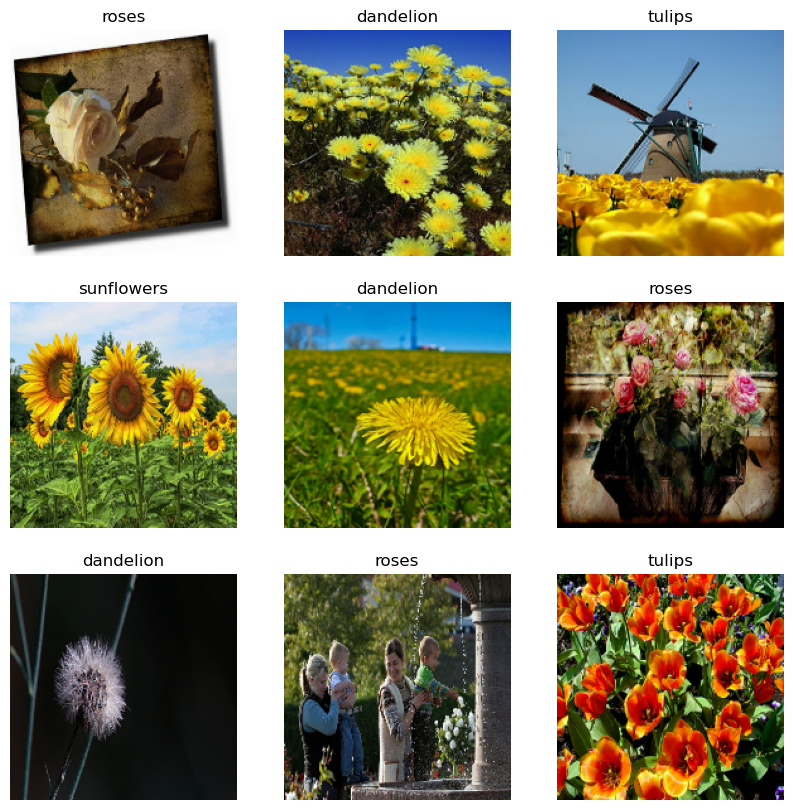

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### é possível treinar um modelo usando esses conjuntos de dados passando-os para model.fit.
também é possível iterar manualmente no conjunto de dados e recuperar lotes de imagens:

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


O image_batch é um tensor da forma (32, 180, 180, 3) . 
Este é um lote de 32 imagens de formato 180x180x3 
(a última dimensão refere-se aos canais de cores RGB). 

O label_batch é um tensor da forma (32,) , estes são os rótulos correspondentes às 32 imagens.

## Padronização dos dados
Os valores do canal RGB estão na faixa [0, 255] . Isso não é ideal para uma rede neural; em geral, 
deve-se procurar tornar seus valores de entrada pequenos.

Aqui, pode-se padronizará os valores para estarem no intervalo [0, 1] usando tf.keras.layers.Rescaling :

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Existem duas maneiras de usar essa camada. Você pode aplicá-lo ao conjunto de dados chamando Dataset.map :

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.96902645


## Treinar um modelo
Para completar, você mostrará como treinar um modelo simples usando os conjuntos de dados que acabou de preparar.

O modelo Sequencial consiste em três blocos de convolução 
- ( tf.keras.layers.Conv2D ) com uma camada de agrupamento máximo 
- ( tf.keras.layers.MaxPooling2D ) em cada um deles. Há uma camada totalmente conectada 
- ( tf.keras.layers.Dense ) com 128 unidades em cima dela que é ativada por uma função de ativação ReLU ( 'relu' ). 

Este modelo não foi ajustado de forma alguma 
- o objetivo é mostrar a mecânica usando os conjuntos de dados que você acabou de criar. Para saber mais sobre classificação de imagens, visite o tutorial Classificação de imagens.

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Escolhendo o otimizador tf.keras.optimizers.Adam e a função de perda tf.keras.losses.SparseCategoricalCrossentropy . 

Para visualizar a precisão do treinamento e da validação para cada época de treinamento, passe o argumento de metrics para Model.compile .

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

treino, kkk

In [31]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 78s 819ms/step - loss: 1.2868 - accuracy: 0.4435 - val_loss: 1.1573 - val_accuracy: 0.5368
Epoch 2/3
92/92 [==============================] - 71s 773ms/step - loss: 1.0177 - accuracy: 0.5855 - val_loss: 1.0011 - val_accuracy: 0.5940
Epoch 3/3
92/92 [==============================] - 72s 778ms/step - loss: 0.8763 - accuracy: 0.6540 - val_loss: 0.9666 - val_accuracy: 0.6199


Se pode notar que a precisão da validação é baixa em comparação com a precisão do treinamento, 
indicando que o modelo está superajustado. 

### Usando tf.data para um controle mais preciso
O utilitário de pré-processamento Keras acima — tf.keras.utils.image_dataset_from_directory — é uma maneira conveniente de criar um tf.data.Dataset a partir de um diretório de imagens.

Para um controle de granulação mais preciso, pode-se escrever o próprio pipeline de entrada usando tf.data . Esta seção mostra como fazer exatamente isso, começando com os caminhos de arquivo do arquivo TGZ que você baixou anteriormente.

In [32]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [33]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\roses\\2197754124_5c8a146761_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\dandelion\\2319777940_0cc5476b0d_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\roses\\7302931078_30054c1970_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\roses\\5835539224_75967fc400_m.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\tulips\\14068348874_7b36c99f6a.jpg'


A estrutura em árvore dos arquivos pode ser usada para compilar uma lista class_names .

In [34]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Dividindo o conjunto de dados em conjuntos de treinamento e validação:

In [35]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [36]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Escreva uma função curta que converta um caminho de arquivo em um par (img, label) :

In [37]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [38]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [39]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map para criar um conjunto de dados de image, label :

In [42]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [43]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


Configurar conjunto de dados para desempenho
Para treinar um modelo com esse conjunto de dados, precisará dos dados:
- Para ser bem embaralhado.
- A ser em lote.
- Lotes a serem disponibilizados o mais rápido possível.

Esses recursos podem ser adicionados usando a API tf.data . Para obter mais detalhes, visite o guia Desempenho do pipeline de entrada .

In [44]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Visualize os dados
Você pode visualizar este conjunto de dados de forma semelhante ao que você criou anteriormente:

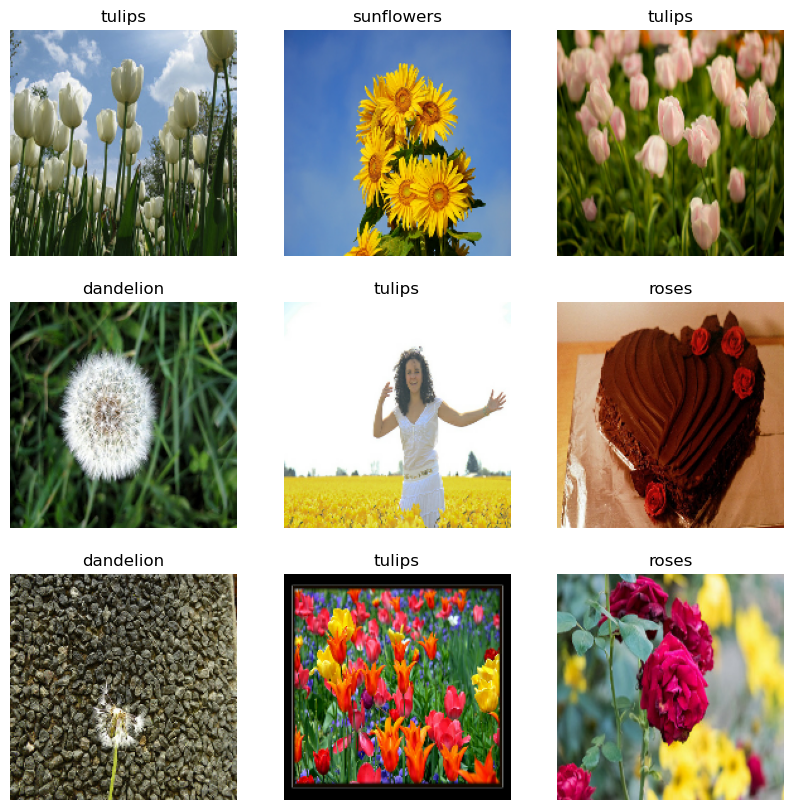

In [45]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Continue treinando o modelo
Você agora construiu manualmente um tf.data.Dataset semelhante ao criado por tf.keras.utils.image_dataset_from_directory acima. Você pode continuar treinando o modelo com ele. Como antes, você treinará por apenas algumas épocas para manter o tempo de execução curto.

In [47]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 75s 812ms/step - loss: 0.3146 - accuracy: 0.8873 - val_loss: 0.9398 - val_accuracy: 0.6757
Epoch 2/3
92/92 [==============================] - 68s 744ms/step - loss: 0.1845 - accuracy: 0.9424 - val_loss: 1.0174 - val_accuracy: 0.7003
Epoch 3/3
92/92 [==============================] - 75s 815ms/step - loss: 0.1169 - accuracy: 0.9642 - val_loss: 1.1027 - val_accuracy: 0.6962


Como usar conjuntos de dados do TensorFlow
Até agora, este tutorial se concentrou no carregamento de dados do disco. 

Também podemos encontrar um conjunto de dados para usar explorando o grande 
catálogo de conjuntos de dados fáceis de baixar em TensorFlow Datasets .

Como carregou anteriormente o conjunto de dados Flowers do disco, 
agora vamos importá-lo com os conjuntos de dados do TensorFlow.

Faça o download do conjunto de dados Flowers usando os conjuntos de dados do TensorFlow:

In [54]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

O conjunto de dados de flores tem cinco classes:

In [55]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Recuperar uma imagem do conjunto de dados:

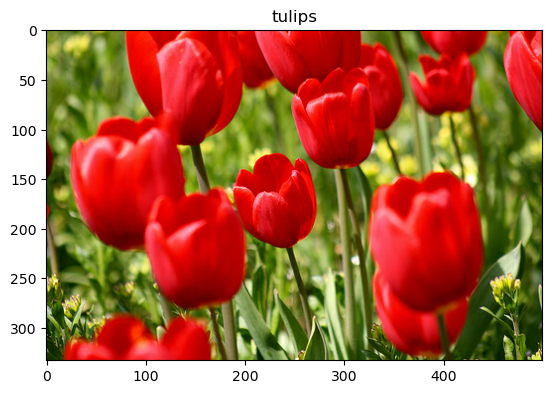

In [56]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

agrupar, embaralhar e configurar os conjuntos de treinamento, validação e teste para desempenho:

In [57]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)